In [1]:
! pip install segmentation_models
! pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 36.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 43.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 18.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.5/38.5 MB 24.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 19.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.1
    Uninstalling numpy-1.23.1:
      Successfully uninstalled numpy-1.23.1
  Attempting uninstall: tifffile
    Found existing installation: tifff

In [9]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Model stuff
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D
from keras.models import Model
from keras.utils import normalize
import segmentation_models as sm
from sklearn.model_selection import train_test_split

import model_utility_rpjb
import preprocess_filter
import spoketools

#path sorting
import glob
from pathlib import Path
import re

#math
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

In [2]:
model_path = "models/rpjb_models/"
type = "all_resnet_test"
training_size = "1020"
epoch_num = "300"
backbone = "resnet34"

model_path = f"{model_path}{type}_spoke_{training_size}im_{epoch_num}e_{backbone}.h5"

In [3]:
X, Y = [], []

X, Y = model_utility_rpjb.data_gather(X, Y, "spokes_all_rpjbs", "spokes_all_masks")

170 170


In [4]:
X = np.array(X)
X = np.stack((X,)*3, axis = -1)
preprocess_input = sm.get_preprocessing(backbone)
X = preprocess_input(X)

Y = np.array(Y)
Y = np.expand_dims(Y, -1)


# train/test split test_size = .15 for light, .25 for dark(no agu)
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)

SIZE_Y, SIZE_X = X.shape[1], X.shape[2]
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(127, 160, 736, 3)
(43, 160, 736, 3)
(127, 160, 736, 1)
(43, 160, 736, 1)


In [5]:
model = model_utility_rpjb.define_model(SIZE_Y, SIZE_X, backbone)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 160, 736, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 160, 736, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 166, 742, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 80, 368, 64)  9408        ['zero_padding2d[0][0]']   

In [6]:
history = model_utility_rpjb.fit_model(x_train, y_train, model, model_path, batch_size = 10, epochs = int(epoch_num), validation_split = .13)
results = model.evaluate(x_test, y_test)
model_utility_rpjb.save_model_history(model_path, model, history, results)

Epoch 1/300
11/11 [==============================] - ETA: 0s - loss: 0.4712 - iou_score: 0.0305
Epoch 1: val_iou_score improved from -inf to 0.02117, saving model to models/rpjb_models/all_resnet_test_spoke_1020im_300e_resnet34.h5
11/11 [==============================] - 22s 596ms/step - loss: 0.4712 - iou_score: 0.0305 - val_loss: 1198.7106 - val_iou_score: 0.0212
Epoch 2/300
11/11 [==============================] - ETA: 0s - loss: 0.2188 - iou_score: 0.0412
Epoch 2: val_iou_score did not improve from 0.02117
11/11 [==============================] - 3s 262ms/step - loss: 0.2188 - iou_score: 0.0412 - val_loss: 6524.2285 - val_iou_score: 0.0045
Epoch 3/300
11/11 [==============================] - ETA: 0s - loss: 0.1543 - iou_score: 0.0535
Epoch 3: val_iou_score improved from 0.02117 to 0.02219, saving model to models/rpjb_models/all_resnet_test_spoke_1020im_300e_resnet34.h5
11/11 [==============================] - 4s 369ms/step - loss: 0.1543 - iou_score: 0.0535 - val_loss: 187.0640 - v

Which model is this? - all_resnet_test_spoke_1020im_300e_resnet34.json


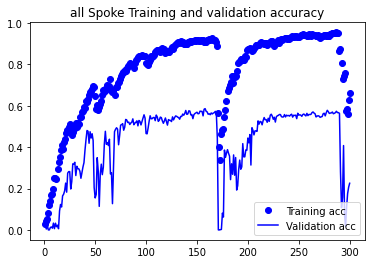

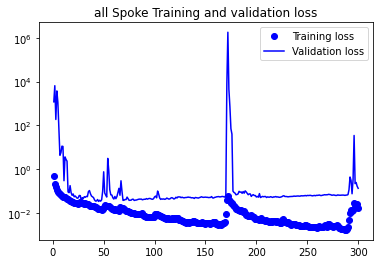

Last Train IOU Score:  0.6629143357276917
Last Train Loss Score:  0.01652274839580059
Last Validation IOU Score:  0.22549547255039215
Last Validation Loss Score:  0.1341601014137268
all_resnet_test
1020
300


In [7]:
model_utility_rpjb.display_results(model_path)
print(type)
print(training_size)
print(epoch_num)

all_resnet_test
1020
300
The spokes_test_rpjbs/ training set is made of 15 images
W1593676089_1_CALIB.rpjb 0
(160, 736)


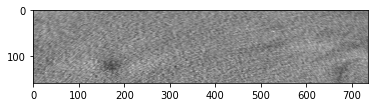

ValueError: in user code:

    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/input_spec.py", line 214, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "model_1" (type Functional).
    
    Input 0 of layer "bn_data" is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: (None, 160, 736)
    
    Call arguments received by layer "model_1" (type Functional):
      • inputs=tf.Tensor(shape=(None, 160, 736), dtype=float32)
      • training=False
      • mask=None


In [10]:
model = keras.models.load_model(model_path, compile = False)
model.compile(optimizer = "Adam" , loss = "binary_crossentropy", metrics = [sm.metrics.IOUScore()], )

print(type)
print(training_size)
print(epoch_num)

model_utility_rpjb.model_testing(model, "spokes_test_rpjbs", 15)